In [84]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [85]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [86]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [87]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [88]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [89]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [90]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [91]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [254]:
#dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname ='ELG_80606_80608_OII.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>0.6) & (SV_depth_catalog['Z']<1.55)]
SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5)]# & (SV_depth_catalog['Z']<1.3)]
print('slope')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>28)]# & (SV_depth_catalog['Z']<1.65)]
print('DELTACHI2_cas>28')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>100)]# & (SV_depth_catalog['Z']<1.62)]
print('DELTACHI2_cas>100')# & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.7959083308743976
Good data completeness: 1.0
Combined value: 0.7959083308743976
--------
DELTACHI2_cas>20
Redshift success rate: 0.9542712355212355
Good data completeness: 0.9773850716757291
Combined value: 0.9326904599280093
--------
slope
Redshift success rate: 0.9828030954428203
Good data completeness: 0.9887543252595156
Combined value: 0.9717508114975291
--------
DELTACHI2_cas>28
Redshift success rate: 0.9699987551350678
Good data completeness: 0.962926347009392
Combined value: 0.9340373578858685
--------
DELTACHI2_cas>100
Redshift success rate: 0.9896380837963659
Good data completeness: 0.8143845773603559
Combined value: 0.8059459926122159


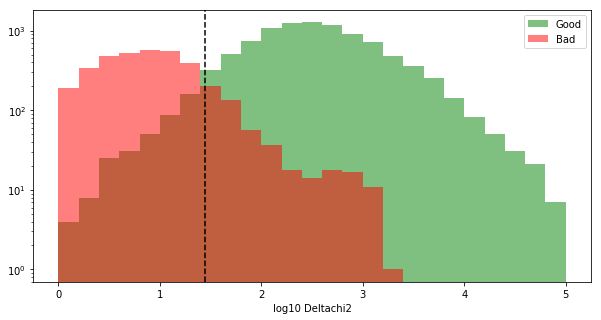

In [137]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=20,color='b',alpha=0.3)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')
#plt.hist(np.log10(bad_2['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='b',label='Bad_1')

plt.axvline(np.log10(28),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

Text(0, 0.5, 'log10 DELTACHI2')

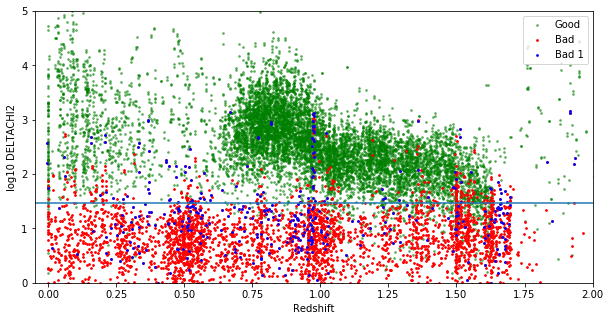

In [138]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

plt.legend()
plt.xlim(-0.05,2)
plt.ylim(0,5)
plt.axhline(np.log10(30))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

Text(0.5, 1.0, 'ELG 80606 & 80608')

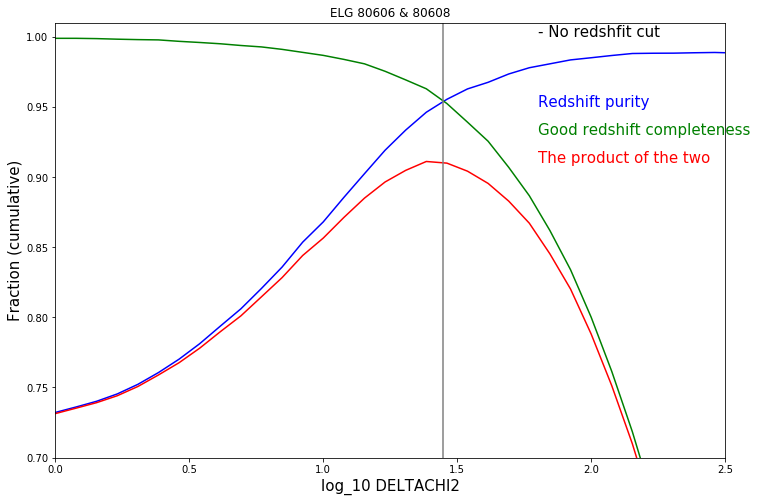

In [139]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0.0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.7,1.01)
plt.xlim(0.0,2.5)
#plt.axhline(0.98,ls='--')
'''
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['Z']<1.65]
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--')
plt.plot(bins,good_fraction,color='g',ls='--')
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--')
'''
plt.text(1.8,1.0,'- No redshfit cut',fontsize=15,color='black')
#plt.text(1.8,0.995,'- - - Redrock z<1.4',fontsize=15,color='black')
plt.text(1.8,0.95,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.93,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.91,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(28),color='grey')
plt.ylabel('Fraction (cumulative)',fontsize=15)
plt.title('ELG 80606 & 80608')

In [44]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog
len(SV_depth_catalog[(SV_depth_catalog['best_quality']<2.5) & (SV_depth_catalog['subset_id']==1)])


1769

Text(0.5, 0, 'FIBERID')

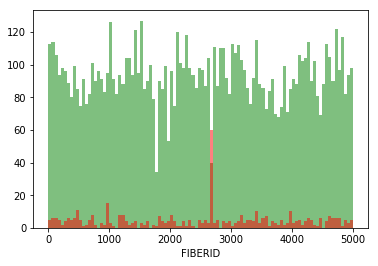

In [96]:
plt.hist(good_catalog['FIBER'][good_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='g')
plt.hist(bad_catalog['FIBER'][bad_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='r')
plt.xlabel('FIBERID')

1962
6871


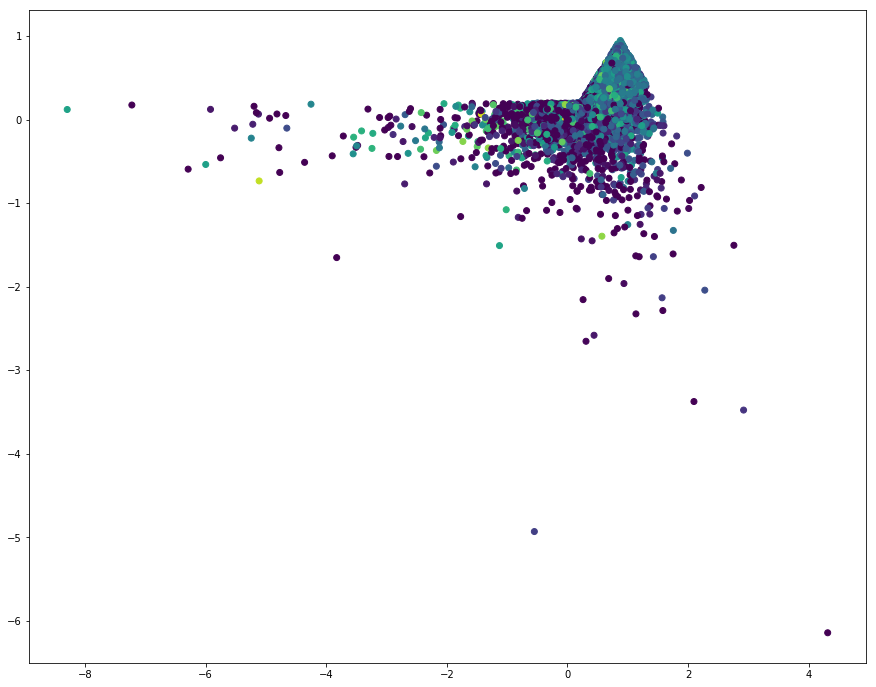

In [122]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']==1]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
print(len(bad_catalog))
print(len(SV_depth_catalog))
plt.figure(figsize=(15,12))
plt.scatter(flux_to_mag(SV_depth_catalog)['rz'],flux_to_mag(SV_depth_catalog)['gr'],c=np.log10(SV_depth_catalog['DELTACHI2_cas']),vmin=1,vmax=5)
#plot_ELG_cc_plot(good_catalog)
#plot_ELG_cc_plot(bad_catalog)

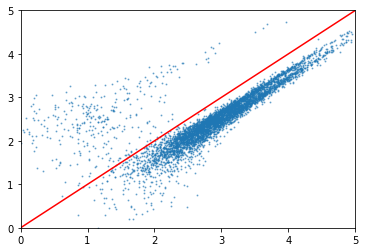

In [135]:
plt.scatter(np.log10(good_catalog['DELTACHI2']),np.log10(good_catalog['DELTACHI2_cas']),s=1,alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10),color='r')

In [120]:
SV_depth_catalog['zwarn'][np.where(np.log10(SV_depth_catalog['DELTACHI2_cas'])-np.log10(SV_depth_catalog['DELTACHI2'])>2)]

array([4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int16)

Text(0, 0.5, 'log10 DELTACHI2')

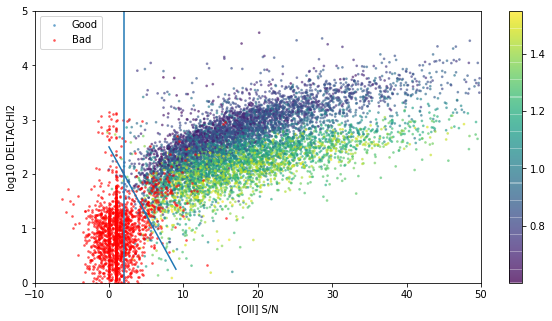

In [241]:
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.55) & (SV_depth_catalog['Z']>0.6)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)

plt.figure(figsize=(10,5))
plt.scatter(good_catalog['FOII']/good_catalog['FOII_ERR'],np.log10(good_catalog['DELTACHI2_cas']),c=good_catalog['Z'],s=3,alpha=0.5,label='Good')
plt.colorbar()
plt.scatter(bad_catalog['FOII']/bad_catalog['FOII_ERR'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=0.5,label='Bad')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

plt.legend()
plt.xlim(-10,50)
plt.ylim(0,5)
x = np.arange(0,10)
y = -0.25*x+2.5
plt.plot(x,y)
plt.axvline(2)
plt.xlabel('[OII] S/N')
plt.ylabel('log10 DELTACHI2')

(array([ 2.,  0.,  0.,  0.,  2.,  0.,  2.,  1.,  0.,  8.,  0.,  0.,  0.,
         1.,  2.,  0.,  2.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,  1.,  1.,  0.,
         6.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  1.,  2.,  1.,  0.,  1.,  2.,  5.,  8.,  5.,  5.,  4.,
         2.,  0.,  1.,  0.,  2., 50., 13.,  4.,  9.]),
 array([0.06722172, 0.0820401 , 0.09685847, 0.11167685, 0.12649522,
        0.1413136 , 0.15613197, 0.17095035, 0.18576872, 0.2005871 ,
        0.21540548, 0.23022385, 0.24504223, 0.2598606 , 0.27467898,
        0.28949735, 0.30431573, 0.3191341 , 0.33395248, 0.34877085,
        0.36358923, 0.3784076 , 0.39322598, 0.40804435, 0.42286273,
        0.43768111, 0.45249948, 0.46731786, 0.48213623, 0.49695461,
        0.51177298, 0.5265

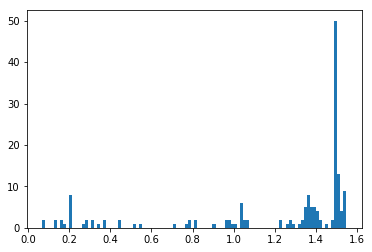

In [176]:
plt.hist(bad_catalog[(bad_catalog['FOII']/bad_catalog['FOII_ERR']>3) & (bad_catalog['FOII']>0)& (bad_catalog['DELTACHI2_cas']>20)]['Z'],bins=100)

array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
       0.60063831])

In [153]:
good_catalog['FOII'][good_catalog['Z']>1.6]

array([-9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999.99,
       -9999.99, -9999.99, -9999.99, -9999.99, -9999.99, -9999